In [1]:
import numpy as np
import math
from math import sqrt
import pandas as pd
import sklearn
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping

In [2]:
#one-hot-encoding: 0 ve 1 atar ve dummy yaratır 44 sütun ekler.
#label encoing: 1-2-3-4 şeklinde tek bir sütunla ülke çiftlerini ayırır. 

Because one-hot encoding adds too many columns and there are too many 0s in these columns, a label encoding approach that is similar to one-hot encoding has been tried.

In [3]:
dff = pd.read_csv("data/export_data_all.csv")
df = dff.copy()
df.head()

,Export,Import,Year,Export_Value,Export_Value_(t-1),GDP_i(t-1),GDP_j(t-1),GDPPC_i(t-1),GDPPC_j(t-1),D_ij,FTA_1,FTA_2
0,Iceland,China,2000,11191.652,5022.337,8.982048e+09,1.093997e+12,32381.625236,873.287062,7861.07,0,1
1,Iceland,France,2000,87202.089,104187.632,8.982048e+09,1.492648e+12,32381.625236,24673.203048,2372.32,0,1
2,Iceland,Germany,2000,312116.389,262963.856,8.982048e+09,2.194204e+12,32381.625236,26725.915218,2246.80,0,1
3,Iceland,Italy,2000,27966.976,34470.260,8.982048e+09,1.252024e+12,32381.625236,21997.624316,3138.62,0,1
4,Iceland,Netherlands,2000,147015.380,120782.848,8.982048e+09,4.468986e+11,32381.625236,28263.096711,1932.09,0,1


Label encoding assigns an integer to variables in the categorical column. It starts the numbering from 0 to the number of unique variables. Unlike one-hot encoding, it changes value of categorical column itself instead of adding a new column. However, the model may assume that there is a ranking within the country pairs because it ranked a non-ordinal values as country pairs.

In order to apply label encoding, 44 country pairs is created by combining the names of importing and exporting countries. After this process, Export and Import columns are dropped.

In [4]:
df["CountryPairs"] = df["Export"] + df["Import"]
df.drop(["Export", "Import"], axis=1, inplace=True)
df

,Year,Export_Value,Export_Value_(t-1),GDP_i(t-1),GDP_j(t-1),GDPPC_i(t-1),GDPPC_j(t-1),D_ij,FTA_1,FTA_2,CountryPairs
0,2000,1.119165e+04,5.022337e+03,8.982048e+09,1.093997e+12,32381.625236,873.287062,7861.07,0,1,IcelandChina
1,2000,8.720209e+04,1.041876e+05,8.982048e+09,1.492648e+12,32381.625236,24673.203048,2372.32,0,1,IcelandFrance
2,2000,3.121164e+05,2.629639e+05,8.982048e+09,2.194204e+12,32381.625236,26725.915218,2246.80,0,1,IcelandGermany
3,2000,2.796698e+04,3.447026e+04,8.982048e+09,1.252024e+12,32381.625236,21997.624316,3138.62,0,1,IcelandItaly
4,2000,1.470154e+05,1.207828e+05,8.982048e+09,4.468986e+11,32381.625236,28263.096711,1932.09,0,1,IcelandNetherlands
...,...,...,...,...,...,...,...,...,...,...,...
875,2019,7.291788e+05,5.131576e+05,7.784719e+11,4.369997e+11,9454.348443,82267.809316,2989.43,1,0,TurkeyNorway
876,2019,8.139094e+06,7.710440e+06,7.784719e+11,1.420300e+12,9454.348443,30349.752098,3401.22,0,1,TurkeySpain
877,2019,1.042018e+06,1.738731e+06,7.784719e+11,7.355393e+11,9454.348443,86388.404953,2328.95,1,0,TurkeySwitzerland
878,2019,1.127900e+07,1.111329e+07,7.784719e+11,2.900791e+12,9454.348443,43646.951971,3332.78,0,1,TurkeyUnited Kingdom


LabelEncoder class is applied to CountryPairs column to make labeled.

In [5]:
encoder = LabelEncoder()
df["CountryPairs"] = encoder.fit_transform(df["CountryPairs"])
df.head()

,Year,Export_Value,Export_Value_(t-1),GDP_i(t-1),GDP_j(t-1),GDPPC_i(t-1),GDPPC_j(t-1),D_ij,FTA_1,FTA_2,CountryPairs
0,2000,11191.652,5022.337,8.982048e+09,1.093997e+12,32381.625236,873.287062,7861.07,0,1,0
1,2000,87202.089,104187.632,8.982048e+09,1.492648e+12,32381.625236,24673.203048,2372.32,0,1,1
2,2000,312116.389,262963.856,8.982048e+09,2.194204e+12,32381.625236,26725.915218,2246.80,0,1,2
3,2000,27966.976,34470.260,8.982048e+09,1.252024e+12,32381.625236,21997.624316,3138.62,0,1,3
4,2000,147015.380,120782.848,8.982048e+09,4.468986e+11,32381.625236,28263.096711,1932.09,0,1,4


In [6]:
columns=['Export_Value', 'Export_Value_(t-1)', 'GDP_i(t-1)', 'GDP_j(t-1)','GDPPC_i(t-1)', 'GDPPC_j(t-1)', 'D_ij']
df[columns]=df[columns].apply(lambda x: np.log(x))
df["Year"]= df["Year"] - 2000

In [7]:
df.head()

,Year,Export_Value,Export_Value_(t-1),GDP_i(t-1),GDP_j(t-1),GDPPC_i(t-1),GDPPC_j(t-1),D_ij,FTA_1,FTA_2,CountryPairs
0,0,9.322923,8.521651,22.918494,27.720859,10.385346,6.772264,8.969678,0,1,0
1,0,11.375984,11.553949,22.918494,28.031573,10.385346,10.113473,7.771624,0,1,1
2,0,12.651131,12.479772,22.918494,28.416841,10.385346,10.193389,7.717262,0,1,2
3,0,10.238780,10.447852,22.918494,27.855782,10.385346,9.998690,8.051538,0,1,3
4,0,11.898292,11.701750,22.918494,26.825597,10.385346,10.249312,7.566358,0,1,4


In [8]:
#min max scalerı y değerleri ve x değerleri için ayrı ayrı uyguladık.
min_max_scaler_y = preprocessing.MinMaxScaler()
df['Export_Value']= min_max_scaler_y.fit_transform(pd.DataFrame(df['Export_Value'])) #y değerleri için minmax
                                                           #İki boyutlu istediği için data frame çevirip atadık.     
columns_mms=['GDP_i(t-1)', 'GDP_j(t-1)','GDPPC_i(t-1)', 'GDPPC_j(t-1)', 'D_ij']
min_max_scaler_x = preprocessing.MinMaxScaler()
df[columns_mms] = min_max_scaler_x.fit_transform(df[columns_mms])  #features için minmax

In [9]:
df

,Year,Export_Value,Export_Value_(t-1),GDP_i(t-1),GDP_j(t-1),GDPPC_i(t-1),GDPPC_j(t-1),D_ij,FTA_1,FTA_2,CountryPairs
0,0,0.239215,8.521651,0.018261,0.624801,0.668563,0.000000,0.915914,0,1,0
1,0,0.426011,11.553949,0.018261,0.664507,0.668563,0.700554,0.522239,0,1,1
2,0,0.542030,12.479772,0.018261,0.713741,0.668563,0.717310,0.504376,0,1,2
3,0,0.322544,10.447852,0.018261,0.642043,0.668563,0.676487,0.614218,0,1,3
4,0,0.473533,11.701750,0.018261,0.510394,0.668563,0.729036,0.454790,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...
875,19,0.619234,13.148338,0.956418,0.507531,0.315679,0.953053,0.598215,1,0,39
876,19,0.838736,15.858086,0.956418,0.658158,0.315679,0.743971,0.640621,0,1,40
877,19,0.651715,14.368666,0.956418,0.574069,0.315679,0.963300,0.516177,1,0,41
878,19,0.868420,16.223652,0.956418,0.749416,0.315679,0.820154,0.633941,0,1,42


In [10]:
y = df['Export_Value']
X = df.drop('Export_Value',axis=1)

In [11]:
x_values = X.values
y_values = y.values

In [12]:
train_row = 748 # 2000-2016
val = 836 # 2017-2018

train_X = x_values[:train_row, :]
validation_X = x_values[train_row:val, :]
test_X = x_values[val:, :]

train_y = y_values[:train_row]
validation_y = y_values[train_row:val]
test_y = y_values[val:]

In [13]:
timesteps=1
train_X = train_X.reshape((train_X.shape[0]//timesteps,timesteps, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0]//timesteps, timesteps, validation_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0]//timesteps, timesteps, test_X.shape[1]))

train_y = train_y.reshape((train_y.shape[0]//timesteps,timesteps,))
validation_y = validation_y.reshape((validation_y.shape[0]//timesteps, timesteps,))
test_y =  test_y.reshape((test_y.shape[0]//timesteps, timesteps,))

print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape, test_y.shape)

(748, 1, 10) (748, 1) (88, 1, 10) (88, 1) (44, 1, 10) (44, 1)


In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [15]:
model = Sequential()
model.add(LSTM(10, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=1000, batch_size=None, validation_data=(validation_X, validation_y), verbose=2, shuffle=False, callbacks=[es])

Epoch 1/1000
24/24 - 2s - loss: 0.3638 - val_loss: 0.3317 - 2s/epoch - 100ms/step
Epoch 2/1000
24/24 - 0s - loss: 0.2107 - val_loss: 0.1800 - 72ms/epoch - 3ms/step
Epoch 3/1000
24/24 - 0s - loss: 0.1064 - val_loss: 0.0900 - 67ms/epoch - 3ms/step
Epoch 4/1000
24/24 - 0s - loss: 0.0487 - val_loss: 0.0444 - 76ms/epoch - 3ms/step
Epoch 5/1000
24/24 - 0s - loss: 0.0308 - val_loss: 0.0331 - 88ms/epoch - 4ms/step
Epoch 6/1000
24/24 - 0s - loss: 0.0269 - val_loss: 0.0305 - 97ms/epoch - 4ms/step
Epoch 7/1000
24/24 - 0s - loss: 0.0236 - val_loss: 0.0291 - 89ms/epoch - 4ms/step
Epoch 8/1000
24/24 - 0s - loss: 0.0211 - val_loss: 0.0263 - 94ms/epoch - 4ms/step
Epoch 9/1000
24/24 - 0s - loss: 0.0190 - val_loss: 0.0238 - 118ms/epoch - 5ms/step
Epoch 10/1000
24/24 - 0s - loss: 0.0164 - val_loss: 0.0188 - 106ms/epoch - 4ms/step
Epoch 11/1000
24/24 - 0s - loss: 0.0111 - val_loss: 0.0089 - 120ms/epoch - 5ms/step
Epoch 12/1000
24/24 - 0s - loss: 0.0115 - val_loss: 0.0109 - 137ms/epoch - 6ms/step
Epoch 13/

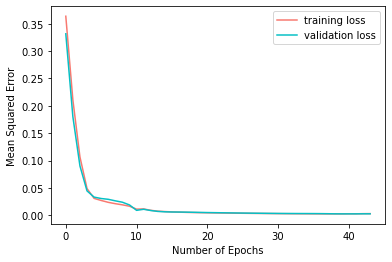

In [16]:
pyplot.plot(history.history['loss'], label='training loss', color='#f87970')
pyplot.plot(history.history['val_loss'], label='validation loss', color='#06c0c5')
pyplot.legend()
pyplot.xlabel("Number of Epochs")
pyplot.ylabel("Mean Squared Error")
pyplot.show()

In [17]:
yhat = model.predict(test_X)

inv_yhat  = min_max_scaler_y.inverse_transform(yhat) #gerçek değerlerine çevirmek için inverse yaptık
# back logunu almadık çünkü ekonomik veriler çok büyük olduğu için insanın aklına yatan bir değer çıkmıyor hata. 
# invert scaling for actual
test_y = test_y.reshape((len(test_y)*timesteps, 1))
inv_y = min_max_scaler_y.inverse_transform(test_y) #inv_real_data
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.549


In [18]:
inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
inv_yhat_y = pd.concat((inv_yhat, inv_y),axis=1)
inv_yhat_y.columns = ["Prediction","2019_Values"]
countries_df = dff[["Export","Import"]].iloc[:44]
prediction_data = pd.concat((countries_df, inv_yhat_y),axis=1)
prediction_data

,Export,Import,Prediction,2019_Values
0,Iceland,China,11.506360,11.773858
1,Iceland,France,13.029932,12.821405
2,Iceland,Germany,12.867514,12.642021
3,Iceland,Italy,11.567097,10.430927
4,Iceland,Netherlands,13.745851,14.133159
5,Iceland,Norway,12.932923,12.215879
6,Iceland,Spain,12.858922,13.113035
7,Iceland,Switzerland,10.935693,9.765879
8,Iceland,Turkey,10.191970,9.908276
9,Iceland,United Kingdom,13.577783,13.206026
